# Applied deep learning with TensorFlow
## Homework preparation notebook
### 0. Environment Setup
Ensuring all required packages are installed.

In [4]:
!pip install tensorflow numpy matplotlib scikit-learn


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Environment verification

This section verifies that:
- TensorFlow is installed and working
- NumPy and Matplotlib are available
- GPU is detected (if available)
- All required packages load without errors

A functional environment prevents runtime failures during the test. Packages installed successfully. Verifying versions below.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
NumPy version: 2.4.2
GPU available: []


### 1. Tensor fundamentals

Deep learning operates entirely on tensors.

Key properties:
- Shape
- Rank (ndim)
- Data type (dtype)

Most bugs in deep learning are shape mismatches, not math errors.

In [3]:
import tensorflow as tf 
import numpy as np 
print("TF:", tf.__version__) 

# 1) Scalars, vectors, matrices, tensors 
scalar = tf.constant(7) # rank-0 
vector = tf.constant([10, 20, 30]) # rank-1 
matrix = tf.constant([[1., 2.], [3., 4.]]) # rank-2 
tensor = tf.constant([[[1],[2]], [[3],[4]]]) # rank-3 (2x2x1) 
print(scalar.shape, vector.shape, matrix.shape, tensor.shape)

# 2) Dtypes and casting 
x = tf.constant([1.7, 7.4]) # float32 default 
y = tf.constant([7, 10]) # int32 default 
x16 = tf.cast(x, tf.float16) # reduced precision floats 
y32 = tf.cast(y, tf.float32) # cast ints → floats 

# 3) Indexing and shaping 
rank2 = tf.constant([[10, 7], [3, 4]]) 
last_col = rank2[:, -1] # column slice 
expanded = tf.expand_dims(rank2, -1) # add channel-like axis

squeezed = tf.squeeze(expanded, axis=-1) 

# 6) Aggregations 
E = tf.constant(np.random.randint(0, 100, size=10)) 
print("min:", tf.reduce_min(E).numpy(), 
      "max:", tf.reduce_max(E).numpy(), 
      "mean:", tf.reduce_mean(tf.cast(E, tf.float32)).numpy(), 
      "sum:", tf.reduce_sum(E).numpy()) 

# 7) One-hot encoding 
idx = tf.constant([0, 1, 2, 3]) 
oh = tf.one_hot(idx, depth=4) 

# 8) NumPy interop 
arr = np.array([3., 7., 10.]) 
t = tf.constant(arr) # NumPy -> Tensor 
back_to_np = t.numpy() # Tensor -> NumPy 
print("OK")


TF: 2.20.0
() (3,) (2, 2) (2, 2, 1)
min: 0 max: 97 mean: 39.0 sum: 390
OK


### Broadcasting

TensorFlow automatically expands dimensions when possible.
Understanding broadcasting prevents silent logic errors.

In [4]:
# 4) Broadcasting & basic ops 
A = tf.constant([[10., 7.], [3., 4.]]) 
print("A+10:\n", A + 10) 
print("A*2:\n", A * 2) 

A+10:
 tf.Tensor(
[[20. 17.]
 [13. 14.]], shape=(2, 2), dtype=float32)
A*2:
 tf.Tensor(
[[20. 14.]
 [ 6.  8.]], shape=(2, 2), dtype=float32)


### Matrix Multiplication Rules

For matrix multiplication:

(A shape: m × n)
(B shape: n × p)

Inner dimensions must match.

In [5]:
# 5) Matrix multiplication rules (inner dims match) 
X = tf.constant([[1, 2], [3, 4], [5, 6]], dtype=tf.float32) # (3x2) 
Y = tf.constant([[7, 8], [9, 10], [11, 12]], dtype=tf.float32) # (3x2) 
XtY = tf.matmul(X, tf.transpose(Y)) # (3x2) @ (2x3) -> (3x3) 
print("Result shape:", XtY.shape)

Result shape: (3, 3)


### 2. Neural Network Regression

Goal:
Learn the function:

    y = x + 10

Key design decisions:
- Output layer: 1 neuron
- No activation (linear output)
- Loss: MAE
- Optimizer: SGD

We evaluate on unseen test data to measure generalization.

Test MAE: 16.234270095825195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


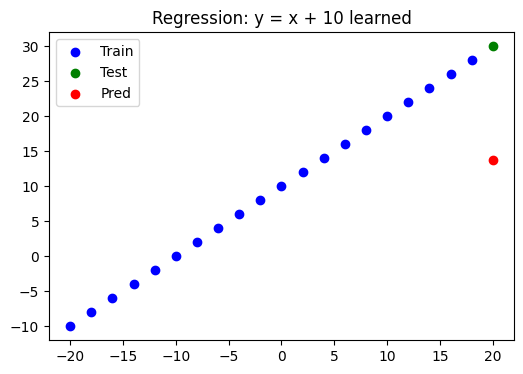

In [7]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
# Synthetic linear data 
X = np.arange(-20, 21, 2, dtype=np.float32) # [-20, -18, ..., 20] 
y = X + 10 

# Reshape 
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Train/test split (simple)
X_train, y_train = X[:20], y[:20] 
X_test, y_test = X[20:], y[20:] 

# 1) CREATE 
model = tf.keras.Sequential([ 
    tf.keras.layers.Input(shape=(1,)), 
    tf.keras.layers.Dense(1) # linear output for regression 
]) 

# 2) COMPILE 
model.compile( 
    loss="mae", 
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
    metrics=["mae"] 
) 

# 3) FIT 
history = model.fit(X_train, y_train, epochs=200, verbose=0) 

# Evaluate 
loss, mae = model.evaluate(X_test, y_test, verbose=0) 
print("Test MAE:", mae) 

# Predict and visualize 
y_pred = model.predict(X_test).squeeze() 
plt.figure(figsize=(6,4)) 
plt.scatter(X_train, y_train, c='b', label='Train') 
plt.scatter(X_test, y_test, c='g', label='Test') 
plt.scatter(X_test, y_pred, c='r', label='Pred')
plt.legend(); plt.title("Regression: y = x + 10 learned") 
plt.show()

#### Observations

- The model learns slope ≈ 1
- Bias ≈ 10
- Small MAE indicates correct generalization

Regression models learn functions, not memorized data.

### 3. Binary classification (non-linear data)

Linear models cannot solve circular separation.

We introduce:
    - ReLU activation (non-linearity)
    - Sigmoid output
    - Binary cross-entropy loss

Test accuracy: 1.000


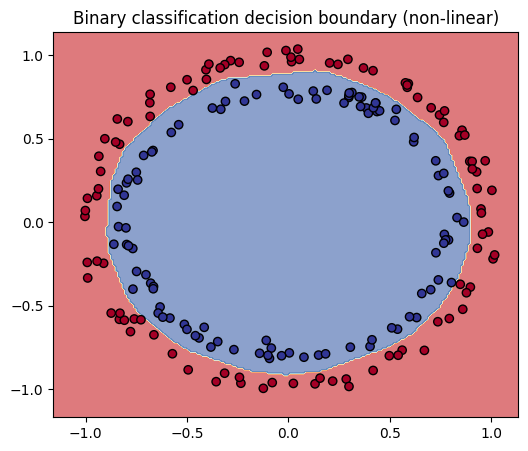

In [10]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split 

# Non-linear separable data 
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# 1) CREATE (use non-linear activations + sigmoid output)
model = tf.keras.Sequential([ 
    tf.keras.layers.Input(shape=(2,)), 
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1, activation="sigmoid") 
]) 

# 2) COMPILE 
model.compile( 
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
    metrics=["accuracy"] 
) 

# 3) FIT 
history = model.fit(X_train, y_train, epochs=25, verbose=0) 

# Evaluate 
loss, acc = model.evaluate(X_test, y_test, verbose=0) 
print(f"Test accuracy: {acc:.3f}") 

# Visualize decision boundary
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.1, X[:,0].max()+0.1, 200), 
                     np.linspace(X[:,1].min()-0.1, X[:,1].max()+0.1, 200)) 
grid = np.c_[xx.ravel(), yy.ravel()] 
probs = model.predict(grid, verbose=0).reshape(xx.shape)
plt.figure(figsize=(6,5)) 
plt.contourf(xx, yy, (probs>0.5).astype(int), cmap=plt.cm.RdYlBu, alpha=0.6) 
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.RdYlBu, edgecolor='k') 
plt.title("Binary classification decision boundary (non-linear)") 
plt.show()



#### Why It Works

- ReLU enables curved decision boundaries
- Sigmoid outputs probability
- Binary crossentropy penalizes incorrect probabilities

Without non-linearity → model fails

### 4. Multiclass Classification

Key Design Choices:
- Flatten layer
- ReLU hidden layer
- Softmax output (10 neurons)
- Sparse categorical crossentropy
- Normalize pixel values to [0,1]

Test accuracy: 0.8835999965667725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


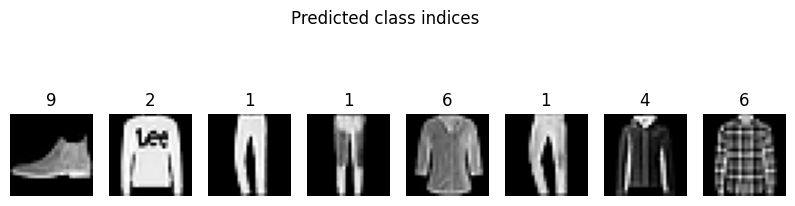

In [13]:
import tensorflow as tf 
import matplotlib.pyplot as plt 

# Load Fashion-MNIST 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 

# Normalize to [0,1] 
x_train = x_train.astype("float32")/255.0 
x_test = x_test.astype("float32")/255.0 

# 1) CREATE (flatten > Dense ReLU > Dense softmax) 
model = tf.keras.Sequential([ 
    tf.keras.layers.Input(shape=(28, 28)), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation="relu"), 
    tf.keras.layers.Dense(10, activation="softmax") 
])

# 2) COMPILE 
model.compile( 
    loss="sparse_categorical_crossentropy", # labels are ints, not one-hot 
    optimizer="adam", 
    metrics=["accuracy"] 
) 

# 3) FIT 
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1, verbose=0) 

# Evaluate 
loss, acc = model.evaluate(x_test, y_test, verbose=0) 
print("Test accuracy:", acc)

#Show a few preds 
preds = model.predict(x_test[:8]).argmax(axis=1) 
plt.figure(figsize=(10,3))
for i in range(8): 
    plt.subplot(1,8,i+1) 
    plt.imshow(x_test[i], cmap='gray') 
    plt.title(int(preds[i])) 
    plt.axis('off') 
plt.suptitle("Predicted class indices"); 
plt.show()

### 5. Convolutional Neural Networks

Dense networks ignore spatial structure.
CNNs preserve spatial relationships.

Architecture:
Conv → Pool → Conv → Pool → Dense → Sigmoid

In [14]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 

# Use Fashion-MNIST but map 2 classes to a binary task (e.g., class 9=Ankle boot vs 7=Sneaker) 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 

# Keep only classes 7 and 9 
train_mask = np.isin(y_train, [7, 9]) 
test_mask = np.isin(y_test, [7, 9]) 

x_train = x_train[train_mask][..., None]/255.0 
y_train = (y_train[train_mask] == 9).astype(np.float32) # 1 if class 9 else 0 
x_test = x_test[test_mask][..., None]/255.0 
y_test = (y_test[test_mask] == 9).astype(np.float32)

# 1) CREATE (small CNN) 
model = tf.keras.Sequential([ 
    tf.keras.layers.Input(shape=(28,28,1)), 
    tf.keras.layers.Conv2D(16, 3, activation="relu"), 
    tf.keras.layers.MaxPool2D(), 
    tf.keras.layers.Conv2D(32, 3, activation="relu"), 
    tf.keras.layers.MaxPool2D(), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation="relu"), 
    tf.keras.layers.Dense(1, activation="sigmoid") 
]) 

# 2) COMPILE 
model.compile( 
    loss="binary_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

# 3) FIT 
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1, verbose=0) 

# Evaluate 
loss, acc = model.evaluate(x_test, y_test, verbose=0) 
print("Test accuracy:", acc)


Test accuracy: 0.9725000262260437


### 6. Model Design Explanation

- The dataset was filtered to include only classes 0, 1, and 2.
- Pixel values were normalized to [0,1] to stabilize training.
- A small CNN was used to extract spatial features.
- The final layer uses softmax activation to output class probabilities.
- Sparse categorical crossentropy is used because labels are integer encoded.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# 1. Load Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 2. Keep classes 0,1,2 only
mask_train = (y_train < 3).flatten()
mask_test  = (y_test < 3).flatten()

x_train = x_train[mask_train].astype("float32") / 255.0
x_test  = x_test[mask_test].astype("float32") / 255.0

y_train = y_train[mask_train].flatten().astype("int32")
y_test  = y_test[mask_test].flatten().astype("int32")

print("Training shape:", x_train.shape)
print("Label shape:", y_train.shape)

# 3. Build CNN Model
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),

    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

model.summary()

# 4. Compile
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 5. Train
history = model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 6. Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy (tiny CNN):", acc)


D:\ML\ml-env\Lib\site-packages\keras\src\datasets\cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Training shape: (15000, 32, 32, 3)
Label shape: (15000,)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,579 (877.26 KB)

 Trainable params: 224,579 (877.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.7311 - loss: 0.6494 - val_accuracy: 0.7907 - val_loss: 0.5086
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.8330 - loss: 0.4206 - val_accuracy: 0.8800 - val_loss: 0.3332
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.8641 - loss: 0.3442 - val_accuracy: 0.8793 - val_loss: 0.3084
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.8858 - loss: 0.2913 - val_accuracy: 0.8993 - val_loss: 0.2689
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9043 - loss: 0.2500 - val_accuracy: 0.8773 - val_loss: 0.3267
Test accuracy (tiny CNN): 0.859000027179718
